# 一、OTFRM计算

In [318]:
import numpy as np
import pandas as pd
import time
import os
import re
from ot_metric import OTFRM

pro_embs_base_pth = "/data1/brian/PLM-PLI/empirical_results/embeddings"
models = ['tape', 'esm1b', 'prottrans']
tasks_list = ['PDBBind', 'Kinase', 'DUDE']
scheme_types = ['random',  'pretrained', 'finetuned']

seed = 42
num_samples = 1000
p = 2
cost_metric = 'cosine'
np.random.seed(seed)
OT_FRM = OTFRM(method='exact', p=p, cost_metric=cost_metric, numItermax=1000000, entreg=.1)

all_models_otfrm = pd.DataFrame(columns=[*tasks_list, 'scheme_type', 'model'])
for model in models:
    all_schemes_otfrm_df = pd.DataFrame(columns=[*tasks_list, 'scheme_type'])
    print("xxx " * 10, model, " xxx"* 10)
    for scheme_type in scheme_types:
        print("=== " * 5, scheme_type, " ===" * 5)
        spec_scheme_all_tasks_embs_dict = {}
        for task_name in tasks_list:
            # matching file
            for pkl in os.listdir(os.path.join(pro_embs_base_pth, model)):
                desc = pkl.split('_')
                task_name_, scheme_type_, model_ = desc[0], desc[2], desc[4]
                if model_==model and scheme_type_==scheme_type and task_name_==task_name:
                    # print(pkl)
                    pro_embs_pkl = pkl
                
            # loading
            pro_embs_pth = os.path.join(pro_embs_base_pth, model, pro_embs_pkl)
            pro_embs = pd.read_pickle(pro_embs_pth)[['pro_id', 'pro_emb']]
            pro_embs = pro_embs.sample(frac=1).reset_index(drop=True)[:num_samples]
            pro_embs = np.stack(pro_embs['pro_emb'].tolist(), axis=0) # list of scalar -> 2d array
            spec_scheme_all_tasks_embs_dict[task_name]= pro_embs

        t0 = time.time()
        spec_scheme_all_tasks_otfrm_dict = OT_FRM.otfrm(spec_scheme_all_tasks_embs_dict)
        print(">> Scheme-{} spends time: {:1f} secs, otfrm: {}".format(scheme_type, time.time()-t0, spec_scheme_all_tasks_otfrm_dict))
        spec_scheme_all_tasks_otfrm_dict['scheme_type'] = scheme_type
        spec_scheme_all_tasks_otfrm_df = pd.DataFrame({k: [v] for k,v in spec_scheme_all_tasks_otfrm_dict.items()})
        all_schemes_otfrm_df = pd.concat([all_schemes_otfrm_df, spec_scheme_all_tasks_otfrm_df], axis=0)

    # check and save
    print(all_schemes_otfrm_df)
    # all_schemes_otfrm_df.to_csv(f"/data1/brian/PLM-PLI/empirical_results/{model}_all_tasks_otfrm.csv", index=False)
    all_schemes_otfrm_df['model'] = model
    all_models_otfrm = pd.concat([all_models_otfrm, all_schemes_otfrm_df], axis=0)
all_models_otfrm = all_models_otfrm.reset_index(drop=True)
all_models_otfrm.to_csv("/data1/brian/PLM-PLI/empirical_results/otfrms.csv", index=False)

xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx  tape  xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx
=== === === === ===  random  === === === === ===
Inter OT-cosine similarity between PDBBind and Kinase: 0.9593
Inter OT-cosine similarity between PDBBind and DUDE: 0.9658
Inter OT-cosine similarity between Kinase and DUDE: 0.9894
 -> Task-PDBBind intra-sim: 0.913883, inter-sim: 0.9625, OTFRM: 0.9495
 -> Task-Kinase intra-sim: 0.978111, inter-sim: 0.9743, OTFRM: 1.0039
 -> Task-DUDE intra-sim: 0.972389, inter-sim: 0.9776, OTFRM: 0.9947
>> Scheme-random spends time: 0.602219 secs, otfrm: {'PDBBind': 0.9494771329531567, 'Kinase': 1.00390259098607, 'DUDE': 0.9947172294212846}
=== === === === ===  pretrained  === === === === ===
Inter OT-cosine similarity between PDBBind and Kinase: 0.0516
Inter OT-cosine similarity between PDBBind and DUDE: 0.0531
Inter OT-cosine similarity between Kinase and DUDE: 0.9903
 -> Task-PDBBind intra-sim: 0.936596, inter-sim: 0.0523, OTFRM: 17.9042
 -> Task-Kinase intra-sim: 0

# 二、作图

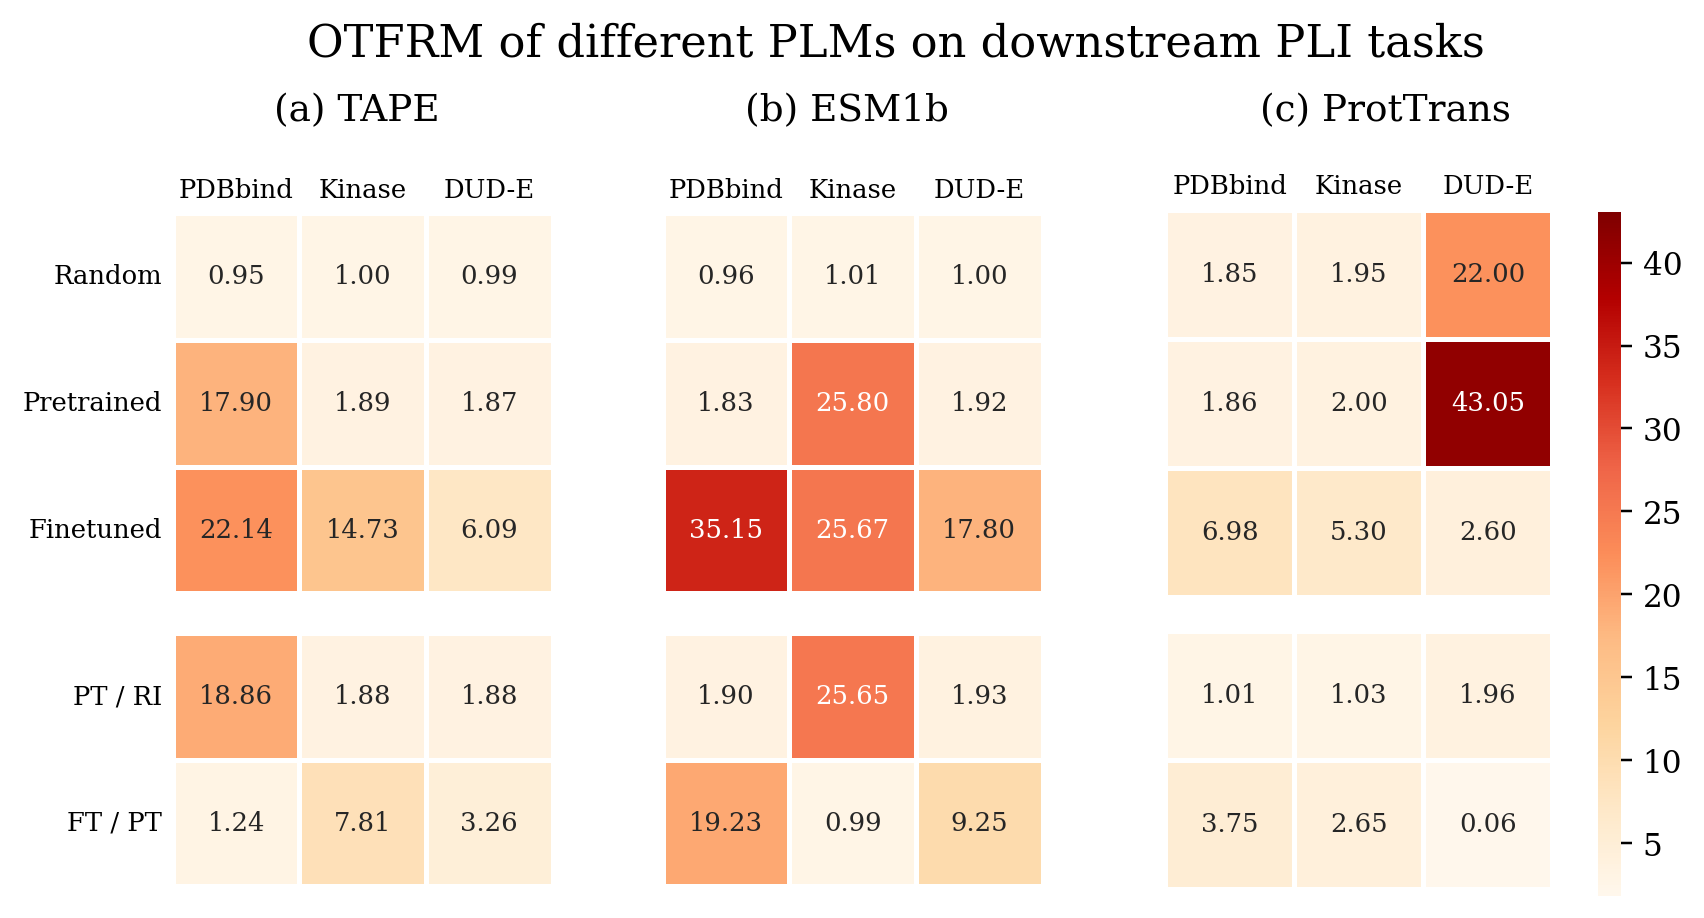

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

titles_dict = {'tape': '(a) TAPE', 'esm1b': '(b) ESM1b', 'prottrans': '(c) ProtTrans'}
# plot heatmap
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.figsize'] = (7, 4.5)

Fig = plt.figure(dpi=224)
Fig_spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 1.0, 1.2], wspace=0.2, hspace=0.0)
# for i, (model, all_schemes_otfrm_df) in enumerate(all_models_otfrm.groupby(all_models_otfrm.model)):
for i, model in enumerate(titles_dict.keys()):
    all_schemes_otfrm_df = all_models_otfrm[all_models_otfrm['model']==model].reset_index(drop=True)
    all_schemes_otfrm_df.drop(columns=['scheme_type', 'model'], inplace=True)
    # all_schemes_otfrm_df = all_schemes_otfrm_df.astype(np.float32)
    fig = Fig.add_subfigure(Fig_spec[i])
    fig.suptitle(titles_dict[model])
    # calculate ratio
    otfrm_ratio_df = pd.DataFrame(columns=['PT / RI', 'FT / PT'])
    otfrm_ratio_df['PT / RI'] = (all_schemes_otfrm_df.iloc[1] / all_schemes_otfrm_df.iloc[0]).tolist()
    otfrm_ratio_df['FT / PT'] = (all_schemes_otfrm_df.iloc[2] / all_schemes_otfrm_df.iloc[1]).tolist()

    # the given number of width/height ratios have to match the number of columns/rows of the grid
    spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 1], wspace=0.5, hspace=-0.15)

    ax1 = fig.add_subplot(spec[0])
    mappable_obj = ax1.imshow(all_schemes_otfrm_df[tasks_list], cmap='OrRd') # get mappable object for fig.colorbar()
    plt.cla()
    ax1 = sns.heatmap(all_schemes_otfrm_df[tasks_list], cmap='OrRd', annot=True, fmt='.2f', annot_kws={'size': 'small'}, cbar=False, linewidths=1, vmin=0, vmax=45)
    ax1.set_xticklabels(['PDBbind', 'Kinase', 'DUD-E'],#  
                        rotation=0, fontsize='small', ha='center')
    ax1.xaxis.tick_top()
    ax1.tick_params(axis=u'both', which=u'both', length=0)
    fig.add_subplot(spec[1], aspect=4/4)
    ax2 = sns.heatmap(otfrm_ratio_df.T, cmap='OrRd', annot=True, fmt='.2f', annot_kws={'size': 'small'}, cbar=False, linewidths=1, vmin=0, vmax=45)
    ax2.get_xaxis().set_visible(False)
    ax2.tick_params(axis=u'both', which=u'both', length=0)

    if i == 0:
        ax1.set_yticklabels(['Random', 'Pretrained', 'Finetuned'], fontsize='small', rotation='horizontal')
        ax2.set_yticklabels(otfrm_ratio_df.columns, rotation='horizontal', size='small')
    else:
        ax1.set_yticklabels("")
        ax2.set_yticklabels("")

cb = fig.colorbar(mappable_obj, ax=[ax1, ax2], location='right', fraction=0.05, pad=0.1, aspect=30, anchor=(0.0, 0.8))
cb.outline.set_visible(False) # hide outline of colorbar
plt.suptitle('OTFRM of different PLMs on downstream PLI tasks', size='x-large', y=1.05)
plt.savefig('./paper_figs/Fig3a.OTFRM.jpg', dpi=2048, bbox_inches='tight')